# Shifting Counties and Polarization in the US

In this report, we will look at a collection of the biggest shifting counties from the US presidential elections in 2016 and 2020. We will analyze some of the factors related to these shifts and attempt to answer the overarching question of whether or not the United States is becoming more polarized.

We will first import a modified csv file containing 2016 and 2020 election results by county courtesy of the github user tonmcg at https://github.com/tonmcg/US_County_Level_Election_Results_08-20

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from IPython.display import Image, HTML

css = "<style>.dataframe th {font-size: 8px;}.dataframe td {font-size: 10px;}</style>"
display(HTML(css))

results = pd.read_csv('election_results.csv',index_col='county_id')
results.sample(5)[['state_name','county_name','votes_dem_2020','votes_gop_2020']]

,state_name,county_name,votes_dem_2020,votes_gop_2020
county_id,,,,
17079,Illinois,Jasper County,1007,4494
40059,Oklahoma,Harper County,136,1327
39115,Ohio,Morgan County,1725,5041
55091,Wisconsin,Pepin County,1489,2584
48163,Texas,Frio County,2422,2823


With this baseline of data in hand, we can now look at some of the counties that shifted the most from 2016 to 2020.

There are some notes to be aware of before getting into the data:
* First we will only be focusing on the Republican and Democratic candidates in each election. Thus, the percentage or vote margins discussed in the report will be the margins between the two main parties.
* Second, margins will be represented as Republican votes minus Democrat votes. As such, a margin with a negative value shows a margin in favor of the Democrats and vice versa.
* Finally, some counties have been omitted from the data for logistical reasons. These include some counties that do not take part in elections and, more notably, there is no data for Alaskan counties because Alaska does not have counties.

With these notes in mind, let us first look at the counties that shifted the most Democratic from 2016 to 2020

In [2]:
counties = results[['county_name','state_name','per_marg_2016','per_marg_2020','per_marg_shift','total_votes_2016','total_votes_2020']].copy()
counties[['per_marg_2016','per_marg_2020','per_marg_shift']]=counties[['per_marg_2016','per_marg_2020','per_marg_shift']].apply(lambda x: round(x,3))
counties.sort_values('per_marg_shift').iloc[:10]

,county_name,state_name,per_marg_2016,per_marg_2020,per_marg_shift,total_votes_2016,total_votes_2020
county_id,,,,,,,
13151,Henry County,Georgia,-0.043,-0.205,-0.161,98037,122998
36021,Columbia County,New York,-0.013,-0.167,-0.153,27255,35522
8111,San Juan County,Colorado,-0.099,-0.249,-0.150,506,563
13247,Rockdale County,Georgia,-0.259,-0.408,-0.149,37589,44681
13117,Forsyth County,Georgia,0.477,0.332,-0.145,97314,129311
13097,Douglas County,Georgia,-0.108,-0.251,-0.144,57365,69106
24003,Anne Arundel County,Maryland,-0.006,-0.145,-0.139,242939,309617
6027,Inyo County,California,0.137,-0.001,-0.138,7996,9481
24021,Frederick County,Maryland,0.040,-0.096,-0.136,114962,145615


The most glaring, and perhaps expected, detail about the biggest Democratic shifters is that 4 of the top 6 counties are in Georgia. Georgia was famously won by Joe Biden in 2020, the first time a Democrat has won in Georgia since 1992. In addition to this fact, all of the counties except San Juan and Inyo had more than 35000 votes cast in the election of 2020. This leads us to our first question:

## Are urban counties becoming more Democratic and are rural counties becoming more Republican?
To answer this question, we will introduce the Rural-Urban Continuum Code (RUCC).  It is famously hard to determine which counties can be classified as rural or urban, but every ten years the USDA classifies all US counties on a nine point scale with 1 being the most urban and 9 being the most rural. The descriptions these classifications are as follows:
#### Metro counties:
1. Counties in metro areas of 1 million population or more
2. Counties in metro areas of 250,000 to 1 million population
3. Counties in metro areas of fewer than 250,000 population

#### Nonmetro counties:
4.	Urban population of 20,000 or more, adjacent to a metro area
5.	Urban population of 20,000 or more, not adjacent to a metro area
6.	Urban population of 2,500 to 19,999, adjacent to a metro area
7.	Urban population of 2,500 to 19,999, not adjacent to a metro area
8.	Completely rural or less than 2,500 urban population, adjacent to a metro area
9.  Completely rural or less than 2,500 urban population, not adjacent to a metro area

We can now import this data from the USDA and join it to our results table to see if there is a relationship. (Note: the lastest RUCC survey occurred in 2013 and codes may be outdated, but provide a good framework nonetheless)

In [3]:
rucc = pd.read_csv('rucc_data.csv',index_col='county_id')
counties_rucc = results.join(rucc['RUCC_2013'])[['state_name','county_name','per_marg_shift','RUCC_2013']]
counties_rucc.sort_values('per_marg_shift').iloc[:10]

,state_name,county_name,per_marg_shift,RUCC_2013
county_id,,,,
13151,Georgia,Henry County,-0.161288,1
36021,New York,Columbia County,-0.153248,6
8111,Colorado,San Juan County,-0.149854,9
13247,Georgia,Rockdale County,-0.148649,1
13117,Georgia,Forsyth County,-0.144666,1
13097,Georgia,Douglas County,-0.143686,1
24003,Maryland,Anne Arundel County,-0.138905,1
6027,California,Inyo County,-0.138170,7
24021,Maryland,Frederick County,-0.135944,1


As we can see, 7 of the top 10 counties that shifted the most Democratic have a RUCC of 1, suggesting an underlying pattern. To confirm our suspiscion, we'll create a box plot to see the relationship. In this diagram, the two extremes show the 5th and 95th percentile, the edges of the box show the 25th and 75th percentile, and the middle line shows the median for each RUCC group.

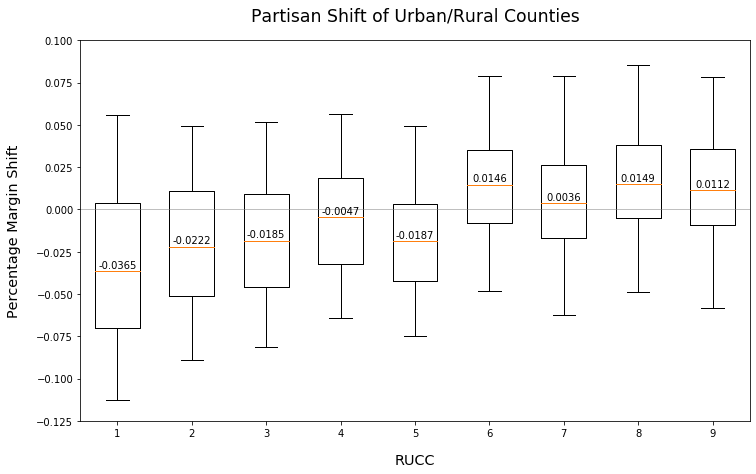

In [4]:
data = [counties_rucc['per_marg_shift'][counties_rucc['RUCC_2013']==i+1] for i in range(9)]  #grouping counties by RUCC
fig, ax = plt.subplots(figsize=(12,7))
box=ax.boxplot(data, showfliers=False, whis=(5,95),widths=.6)
ax.set_ylim([-.125,.1])
ax.axhline(0, color='gray',linewidth=0.5)

for i, m in enumerate(box['medians']):
    ax.annotate(round(m.get_ydata()[0],4),(i+1,m.get_ydata()[0]+.002),ha='center')

ax.set_xlabel('RUCC',fontsize='x-large',labelpad=15)
ax.set_ylabel('Percentage Margin Shift',fontsize='x-large',labelpad=15)
ax.set_title('Partisan Shift of Urban/Rural Counties',fontsize='xx-large',pad=20)
plt.show()

As we can see, although there is some variability between counties in each group, there is a clear relationship between how urban or rural a county is and how much it shifted between the 2016 and 2020 elections. We'll calculate the correlation coefficient and a trend line comparing RUCC to percentage shift, then plot the line along with the mean for each code to see the relationship more clearly

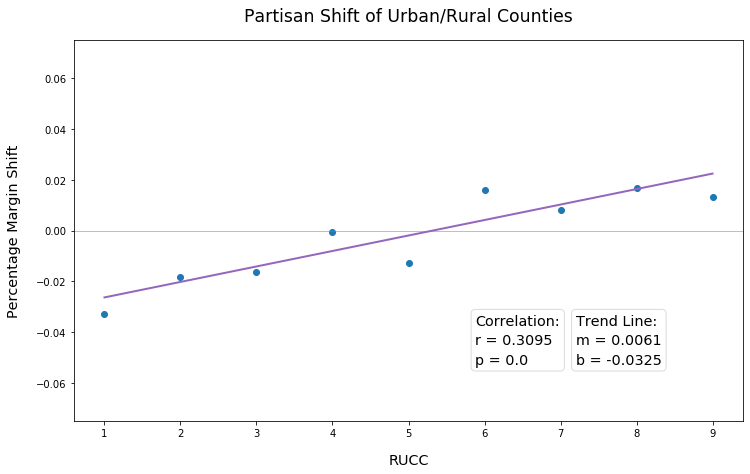

In [5]:
means = counties_rucc.groupby('RUCC_2013').mean()['per_marg_shift']
m, b = np.polyfit(counties_rucc['RUCC_2013'],counties_rucc['per_marg_shift'],1)
r, p = stats.pearsonr(counties_rucc['RUCC_2013'],counties_rucc['per_marg_shift'])

x = np.arange(9)+1
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(x,means)
ax.plot(x,m*x+b,linewidth=2,c='C04')
ax.set_ylim([-.075,.075])
ax.axhline(0, color='gray',linewidth=0.5)

ax.set_xlabel('RUCC',fontsize='x-large',labelpad=15)
ax.set_ylabel('Percentage Margin Shift',fontsize='x-large',labelpad=15)
ax.set_title('Partisan Shift of Urban/Rural Counties',fontsize='xx-large',pad=20)

ax.text(.6,.15,f"Correlation:\nr = {round(r,4)}\np = {round(p,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax.text(.75,.15,f"Trend Line:\nm = {round(m,4)}\nb = {round(b,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
plt.show()

With a correlation coefficient of 0.31 and a p-value of zero, we can say there is a moderate but statistically significant linear relationship between RUCC and partisan shift, and when comparing the trend line to the means, the relationship is visibly clear. Armed with this insight, let's now look at the most Republican shifting counties in the 2020 election.

In [6]:
counties.join(rucc['RUCC_2013']).sort_values('per_marg_shift',ascending=False).iloc[:10].drop(['total_votes_2016','total_votes_2020'],axis=1)

,county_name,state_name,per_marg_2016,per_marg_2020,per_marg_shift,RUCC_2013
county_id,,,,,,
48427,Starr County,Texas,-0.601,-0.050,0.551,4
48323,Maverick County,Texas,-0.558,-0.095,0.463,5
48261,Kenedy County,Texas,-0.081,0.320,0.400,9
48247,Jim Hogg County,Texas,-0.569,-0.179,0.390,6
48505,Zapata County,Texas,-0.328,0.053,0.381,6
5111,Poinsett County,Arkansas,0.241,0.598,0.357,3
48131,Duval County,Texas,-0.353,-0.026,0.327,7
48047,Brooks County,Texas,-0.510,-0.190,0.320,7
48389,Reeves County,Texas,-0.076,0.233,0.309,7


As we expect, 9 out of the top 10 most Republican shifting counties are considered non-metro by the RUCC. But perhaps more shockingly, 8 of the top 10 counties are from Texas, and all of those counties voted in favor of Hillary Clinton in 2016. This goes against the recent conventional wisdom that Texas has been shifting more Democratic in recent years. We know that being more rural explains some of the shift, but this clearly doesn't tell the whole story. Perhaps looking at a map of these counties will give us some clues.

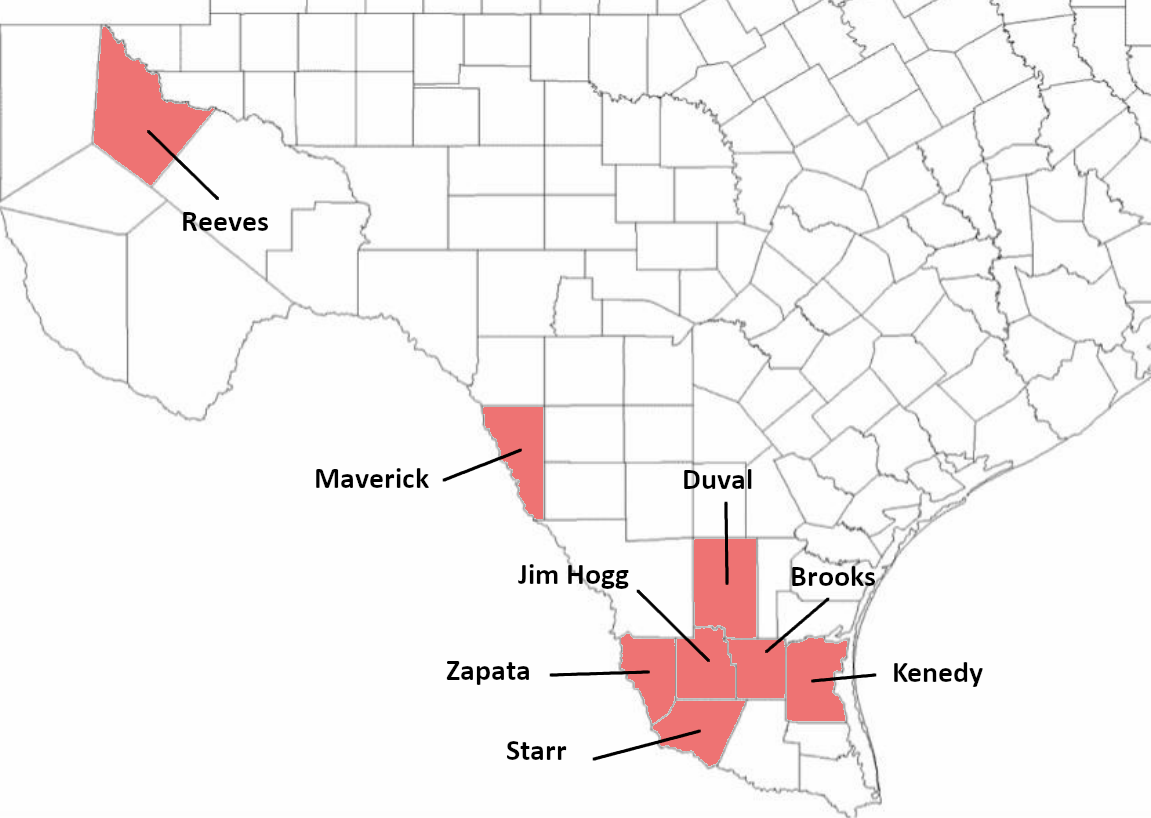

In [7]:
Image(filename="texas_counties.png",width=500,height=500)

We see that all of the 8 counties in Texas are on or near the Mexican border. This naturally gives rise to our next question:

## How is race related to partisan shift?
This question may be a little difficult to answer given the data available to us. Given the nature of holding an election in a pandemic, the exit polls from 2020 may not be accurate, and race data for exit polls rarely get to the granular level of counties. However, we can use race data from the US Census Bureau to see the racial make up of each county and use that to determine the effect of race on partisan shift. We must note, however, that this is NOT the racial make up of the electorate, in which the share of people of color is often less than the population as a whole. Minding this caveat, we start by importing Census Bureau data regarding the racial make up of each county

In [8]:
race = pd.read_csv('race_data.csv',index_col='county_id')
race[['per_hisp','per_black','per_white']] = race[['per_hisp','per_black','per_white']].apply(lambda x: round(x,3))
race.sample(5)

,county_name,state_name,tot_pop,per_hisp,per_black,per_white
county_id,,,,,,
2188,Northwest Arctic Borough,Alaska,7673,0.025,0.018,0.111
48041,Brazos County,Texas,220417,0.251,0.119,0.564
19037,Chickasaw County,Iowa,12023,0.021,0.011,0.963
27073,Lac qui Parle County,Minnesota,6715,0.021,0.010,0.954
6063,Plumas County,California,18627,0.090,0.020,0.833


For the purposes of this report, we will be focusing only on Hispanic, White, and Black populations. Using the map of Texas as motivation, we'll begin by looking at Hispanics by joining the column onto the top 10 Republican shifting counties.

In [9]:
counties_hisp = counties.join(race['per_hisp'])[['county_name','state_name','per_marg_shift','per_hisp']]
counties_hisp.sort_values('per_marg_shift',ascending=False).iloc[:10]

,county_name,state_name,per_marg_shift,per_hisp
county_id,,,,
48427,Starr County,Texas,0.551,0.963
48323,Maverick County,Texas,0.463,0.953
48261,Kenedy County,Texas,0.400,0.733
48247,Jim Hogg County,Texas,0.390,0.924
48505,Zapata County,Texas,0.381,0.946
5111,Poinsett County,Arkansas,0.357,0.029
48131,Duval County,Texas,0.327,0.894
48047,Brooks County,Texas,0.320,0.904
48389,Reeves County,Texas,0.309,0.751


Surely enough, all of the Texas counties in the top ten have very high proportions of Hispanics in their population. This is good evidence that the Hispanic population shifted fairly substantially toward Donald Trump in 2020. To test our theory, we'll plot the proportion of Hispanics in a county against their partisan shift. 

We will take the liberty of looking only at counties with Hispanic populations of above 30 percent. This is done for two reasons. First, it will greatly declutter the data being shown, as only 226 of the 3014 counties in our dataset meet this criterion. Second, we want to look at counties where we can assume the Hispanic population has a sizeable influence on the electorate. For example, we would expect the partisan shift of a county with a Hispanic population of  5 percent to be influenced much more by other factors, like its RUCC, than its Hispanic identity. We'll admit that the choice of 30 percent is somewhat arbitrary, but it serves our purposes well. With that being said, let's take a look at the data.

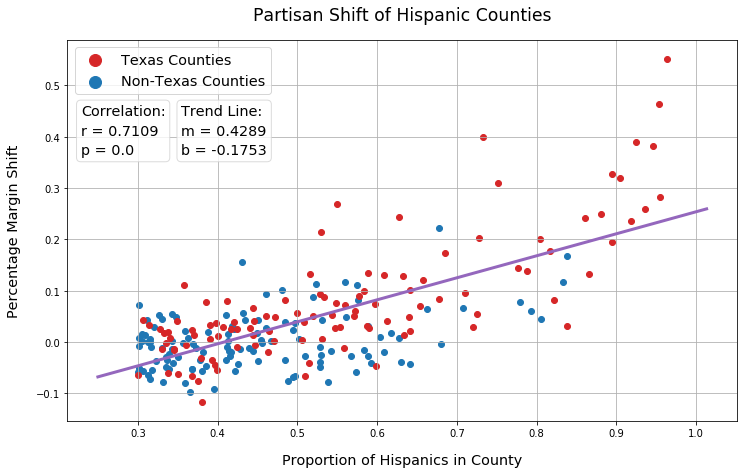

In [10]:
counties_hisp = counties_hisp[counties_hisp['per_hisp']>=.3]
texas_hisp = counties_hisp[(counties_hisp['state_name']=='Texas')]
non_texas_hisp = counties_hisp[~counties_hisp.isin(texas_hisp).all(1)]
m, b = np.polyfit(counties_hisp['per_hisp'],counties_hisp['per_marg_shift'],1)
r, p = stats.pearsonr(counties_hisp['per_hisp'],counties_hisp['per_marg_shift'])

x = np.array([counties_hisp['per_hisp'].min()-.05,counties_hisp['per_hisp'].max()+.05])

fig, ax = plt.subplots(figsize=(12,7))
texas = ax.scatter(non_texas_hisp['per_hisp'],non_texas_hisp['per_marg_shift'])
non_texas = ax.scatter(texas_hisp['per_hisp'],texas_hisp['per_marg_shift'], c='C03')
ax.plot(x,m*x+b,c='C04',linewidth=3)

ax.set_xlabel('Proportion of Hispanics in County',fontsize='x-large',labelpad=15)
ax.set_ylabel('Percentage Margin Shift',fontsize='x-large',labelpad=15)
ax.set_title('Partisan Shift of Hispanic Counties',fontsize='xx-large',pad=20)
ax.legend((non_texas,texas),('Texas Counties','Non-Texas Counties'),fontsize='x-large',markerscale=2)

r, p = stats.pearsonr(counties_hisp['per_hisp'],counties_hisp['per_marg_shift'])

ax.text(.02,.7,f"Correlation:\nr = {round(r,4)}\np = {round(p,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax.text(.17,.7,f"Trend Line:\nm = {round(m,4)}\nb = {round(b,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

plt.grid()
plt.show()

We can see a quite substantial, and perhaps shocking, relationship between the proportion of Hispanics in a county and the Republican shift of the county. In particular, Hispanic counties in Texas saw a huge shift toward Trump in 2020. This is a very intriguing development, as one might expect this shift to be in the opposite direction given Trump's strong anti-immigrant stance. We must also note that the Hispanic population in the US is very diverse, and a Mexican in Texas will probably not have the same priorities as a Cuban in Florida. Nonetheless, it will be interesing to see if and how each party changes their platform given this information.

Knowing that Hispanic counties shifted toward Republicans in 2020 begs the question of whether other races had a sizable shift as well. Let's look at the Black population first, and we'll use the same 30 percent cutoff that we did for the Hispanic population.

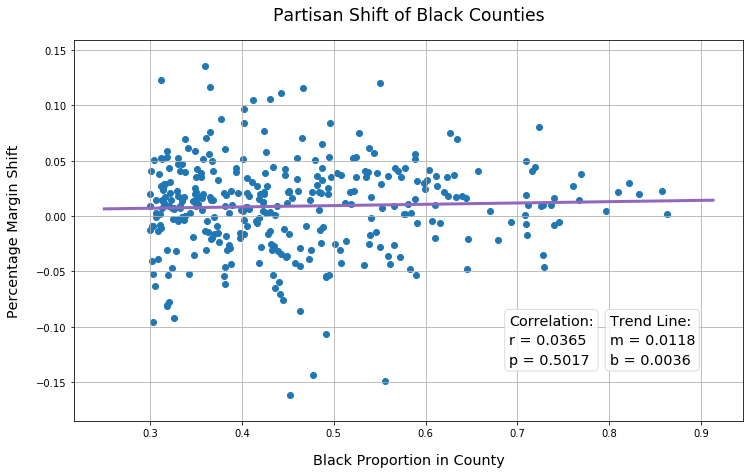

In [11]:
counties_black = results.join(race['per_black'])[['state_name','county_name','per_marg_shift','per_black']]
counties_black = counties_black[counties_black['per_black']>=.3]
m, b = np.polyfit(counties_black['per_black'],counties_black['per_marg_shift'],1)
r, p = stats.pearsonr(counties_black['per_black'],counties_black['per_marg_shift'])

x = np.array([counties_black['per_black'].min()-.05,counties_black['per_black'].max()+.05])

fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(counties_black['per_black'],counties_black['per_marg_shift'])
ax.plot(x,m*x+b,c='C04',linewidth=3)

ax.set_xlabel('Black Proportion in County',fontsize='x-large',labelpad=15)
ax.set_ylabel('Percentage Margin Shift',fontsize='x-large',labelpad=15)
ax.set_title('Partisan Shift of Black Counties',fontsize='xx-large',pad=20)

ax.text(.65,.15,f"Correlation:\nr = {round(r,4)}\np = {round(p,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax.text(.8,.15,f"Trend Line:\nm = {round(m,4)}\nb = {round(b,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

plt.grid()
plt.show()

There is virtually no correlation between the Black proportion of a county and their partisan shift. Now, this certainly does not mean there is no correlation between Black counties and partisanship in general, something we'll discuss later when talking about polarization. However, this data does suggest that the events between 2016 and 2020 did little to change the opinions of the Black community on the two parties' presidential candidates.

To finish our discussion on race, we'll look at White populations. For this analysis, we'll be using the non-Hispanic White population and again use the 30 percent threshold we used for Hispanic and Black populations.

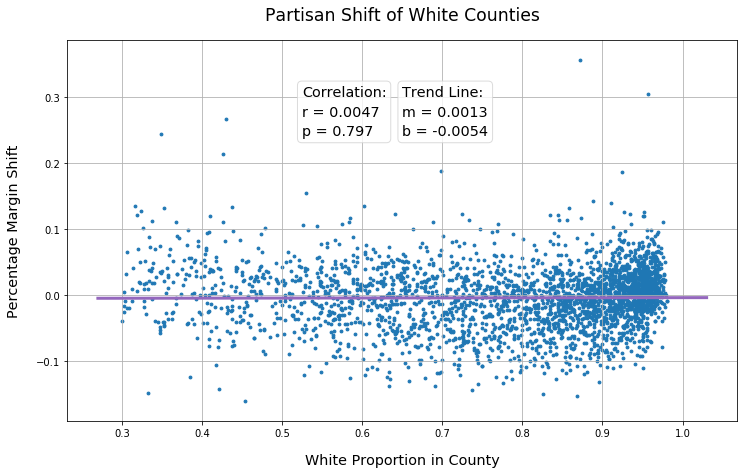

In [12]:
counties_white = results.join(race['per_white'])[['state_name','county_name','per_marg_shift','per_white']]
counties_white = counties_white[counties_white['per_white']>=.3]
m, b = np.polyfit(counties_white['per_white'],counties_white['per_marg_shift'],1)
r, p = stats.pearsonr(counties_white['per_white'],counties_white['per_marg_shift'])

x = np.array([counties_white['per_white'].min()-.03,counties_white['per_white'].max()+.05])

fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(counties_white['per_white'],counties_white['per_marg_shift'],s=8)
ax.plot(x,m*x+b,c='C04',linewidth=3)

ax.set_xlabel('White Proportion in County',fontsize='x-large',labelpad=15)
ax.set_ylabel('Percentage Margin Shift',fontsize='x-large',labelpad=15)
ax.set_title('Partisan Shift of White Counties',fontsize='xx-large',pad=20)

ax.text(.35,.75,f"Correlation:\nr = {round(r,4)}\np = {round(p,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax.text(.5,.75,f"Trend Line:\nm = {round(m,4)}\nb = {round(b,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

plt.grid()
plt.show()

Again, similar to Black counties, there is minimal correlation between how White a county is and how much it shifted in the 2020 election. However, we know that White counties have shifted, as evidenced by the large vertical spread in the data points seen in the scatter plot, it just appears that race itself doesn't account for that shift. We've seen that RUCC accounts for some of that shift, but are there other factors that correlate with partisan shift? One might look at something related to the rural/urban distinction to find hints, and that's just what we'll do with two separate but related indicators.

## Do education and income correlate with partisan shift?
We'll look at two more data sets, again from the USDA. One contains the educational attainment of counties at various levels, the other contains the median income, the median income as a percentile of all counties, and unemployment rate. 

In [13]:
edu = pd.read_csv('edu_data.csv',index_col='county_id')
income = pd.read_csv('income_data.csv',index_col='county_id')
s=edu.join(income['median_income']).sample(5)[['county_name','state','per_hs_only','per_some_col','per_bach_deg','median_income']]
s['median_income']=s['median_income'].astype('int32')
s

,county_name,state,per_hs_only,per_some_col,per_bach_deg,median_income
county_id,,,,,,
4013,Maricopa County,AZ,0.226,0.328,0.320,68634
26003,Alger County,MI,0.443,0.275,0.174,52285
26069,Iosco County,MI,0.378,0.349,0.163,43605
48147,Fannin County,TX,0.358,0.324,0.167,56123
53037,Kittitas County,WA,0.235,0.338,0.348,59172


The first thing we'll do is return to our scatter plot of white counties and add a third variable in the form of a color map, and see if it adds some more order to the uncorrelated data. This variable will indicate the percentage of a county's population that went to college, either attaining a degree or not. (Note: The legend on the right is inverted for visual consistency)

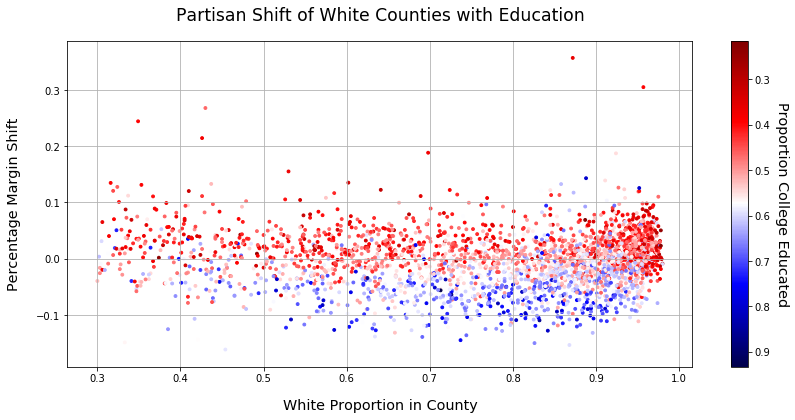

In [14]:
counties_white_edu = counties_white.join(edu['per_col'])
fig, ax = plt.subplots(figsize=(14,6))
s = ax.scatter(counties_white_edu['per_white'],counties_white_edu['per_marg_shift'],s=8,c=counties_white_edu['per_col'],cmap='seismic_r')

cbar = fig.colorbar(s)
cbar.ax.invert_yaxis()
cbar.set_label('Proportion College Educated',size='x-large',rotation=270,labelpad=18)

ax.set_xlabel('White Proportion in County',fontsize='x-large',labelpad=15)
ax.set_ylabel('Percentage Margin Shift',fontsize='x-large',labelpad=15)
ax.set_title('Partisan Shift of White Counties with Education',fontsize='xx-large',pad=20)

plt.grid()
plt.show()

The relationship seems quite clear. Those who are college educated shifted toward the Democrats, and those who are not shifted toward the Republicans. We'll look at a scatter plot of the of this relationship to confirm this relationship, while also adding a color map for median income, which correlates with education. (Note: We will remove the 10 biggest Repblican outliers from the scatter plot for aesthetic reasons. They are included in statistical calculations.)

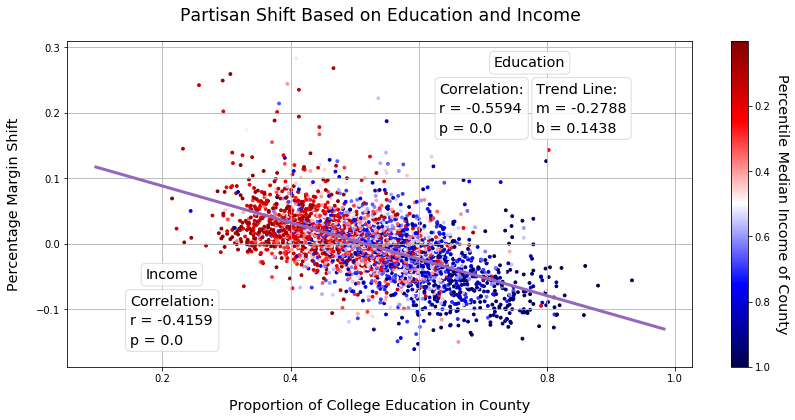

In [15]:
counties_edu_income = counties.join([edu['per_col'],income['median_income_pct']]).dropna()
scatter = counties_edu_income.sort_values('per_marg_shift').iloc[:-10]
fig, ax = plt.subplots(figsize=(14,6))
s = ax.scatter(scatter['per_col'],scatter['per_marg_shift'],s=8,c=scatter['median_income_pct'],cmap='seismic_r')

m, b = np.polyfit(counties_edu_income['per_col'],counties_edu_income['per_marg_shift'],1)
r1, p1 = stats.pearsonr(counties_edu_income['per_col'],counties_edu_income['per_marg_shift'])
r2, p2 = stats.pearsonr(counties_edu_income['median_income_pct'],counties_edu_income['per_marg_shift'])


x = np.array([counties_edu_income['per_col'].min()-.03,counties_edu_income['per_col'].max()+.05])
ax.plot(x,m*x+b,c='C04',linewidth=3)

cbar = fig.colorbar(s)
cbar.ax.invert_yaxis()
cbar.set_label('Percentile Median Income of County',size='x-large', rotation=270,labelpad=18)

ax.set_xlabel('Proportion of College Education in County',fontsize='x-large',labelpad=15)
ax.set_ylabel('Percentage Margin Shift',fontsize='x-large',labelpad=15)
ax.set_title('Partisan Shift Based on Education and Income',fontsize='xx-large',pad=20)

ax.text(.6825,.92,'Education',size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax.text(.595,.72,f"Correlation:\nr = {round(r1,4)}\np = {round(p1,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax.text(.75,.72,f"Trend Line:\nm = {round(m,4)}\nb = {round(b,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax.text(.125,.27,'Income',size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax.text(.1,.07,f"Correlation:\nr = {round(r2,4)}\np = {round(p2,4)}",size='x-large',linespacing=1.5,transform=ax.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

plt.grid()
plt.show()

The correlation is clear, strong, and significant. Education and income appear to be good indicators for explaning the partisan shift of counties in from the 2016 to 2020 US Presidential elections. It remains to be seen whether this trend will continue after the Trump presidency, or if this is an anomaly specific to the 2020 election.

Now that we've looked at some of the possible factors that can explain the partisan shift of US counties, we will attempt to use the data and insight we've acquired to answer a difficult and important question.

## Is the US becoming more polarized?
First, it will help to explain what we mean by "polarized". In general, when we say the country is polarized we mean that political views are becoming more extreme, with little overlapping values and ability to compromise. But how do we quantify polarization? One way is to look at the gap in voting margins of particular groups in a past election, and see if those margins became more pronounced in a future election. We'll start by doing this with RUCC.

We'll group all the votes cast in each RUCC and look at the percentage margins for each group in 2016 and 2020. This is similar to the analysis we did originally on RUCC, but now we're aggregating votes instead of counties. This adresses the problem of equating Los Angeles County, CA, which had 4,263,443 votes cast in 2020 with Calhoun County, IL, which had 2,773, while both h have a RUCC of 1. We'll also aggregate the RUCCs classified as Metro and Non-Metro.

In [16]:
marg_rucc = results.join(rucc['RUCC_2013'])[['total_votes_2016','votes_marg_2016','total_votes_2020','votes_marg_2020','RUCC_2013']]
marg_rucc = marg_rucc.groupby('RUCC_2013').sum()
marg_rucc.loc['Metro'] = marg_rucc.iloc[:3].sum()
marg_rucc.loc['Non-Metro'] = marg_rucc.iloc[3:9].sum()
marg_rucc['per_marg_2016'] = round(marg_rucc['votes_marg_2016']/marg_rucc['total_votes_2016'],3)
marg_rucc['per_marg_2020'] = round(marg_rucc['votes_marg_2020']/marg_rucc['total_votes_2020'],3)
marg_rucc['per_marg_shift'] = round(marg_rucc['per_marg_2020']-marg_rucc['per_marg_2016'],3)
marg_rucc[['total_votes_2016','votes_marg_2016','total_votes_2020','votes_marg_2020']]=marg_rucc[['total_votes_2016','votes_marg_2016','total_votes_2020','votes_marg_2020']].astype('int32')
marg_rucc

,total_votes_2016,votes_marg_2016,total_votes_2020,votes_marg_2020,per_marg_2016,per_marg_2020,per_marg_shift
RUCC_2013,,,,,,,
1,70382965,-11297357,87859253,-16753544,-0.161,-0.191,-0.030
2,28035890,1320685,33778349,340955,0.047,0.010,-0.037
3,12120453,2306562,14274739,2249751,0.190,0.158,-0.032
4,5658923,1456785,6612213,1635646,0.257,0.247,-0.010
5,1961779,454847,2303891,442525,0.232,0.192,-0.040
6,6149490,2256869,6979591,2605513,0.367,0.373,0.006
7,3440486,1253656,3830767,1382140,0.364,0.361,-0.003
8,983204,353968,1106100,415507,0.360,0.376,0.016
9,1175495,532359,1294108,590754,0.453,0.456,0.003


Notice that the only RUCC that voted for the Democrat in both 2016 and 2020 was 1, the most urban. This a little surprising at first, but not when you realize that it accounts for more thatn 54% of the total electorate. This alone hints that the US was already very polarized on a rural/urban divde in 2016. We'll look at a bar chart comparing the the margins in 2016 and 2020 for both metro and non-metro voters.

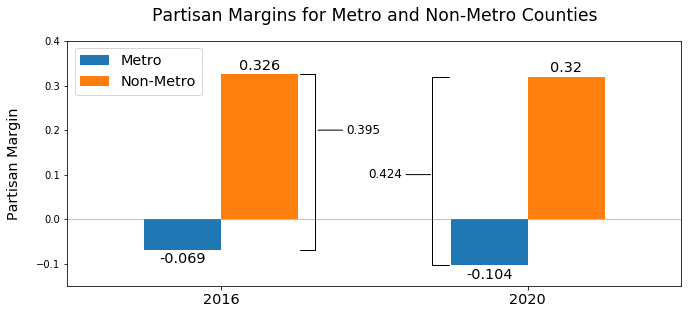

In [17]:
metro = [marg_rucc.loc['Metro','per_marg_2016'],marg_rucc.loc['Metro','per_marg_2020']]
non_metro = [marg_rucc.loc['Non-Metro','per_marg_2016'],marg_rucc.loc['Non-Metro','per_marg_2020']]

width = 0.25  # the width of the bars
x = np.array([0,1])

fig, ax = plt.subplots(figsize=(11,4.5))
bar_2016 = ax.bar(x - width/2, metro, width, label='Metro')
bar_2020 = ax.bar(x + width/2, non_metro, width, label='Non-Metro')

ax.set_xlim([-width-.1,width+1.1])
ax.set_ylim([-.15,.4])
ax.set_xlim([-.5,1.5])

ax.axhline(0, color='gray',linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(['2016', '2020'],fontsize='x-large')
ax.legend(fontsize='x-large',loc='upper left')

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(round(p.get_height(),3), (p.get_x()+width/2, p.get_height()+.01),ha='center',size='x-large')
    elif p.get_height() < 0:
        ax.annotate(round(p.get_height(),3), (p.get_x()+width/2, p.get_height()-.03),ha='center',size='x-large')

ax.annotate('',xy=(width,metro[0]),xytext=(width,non_metro[0]),
           arrowprops=dict(arrowstyle='-',connectionstyle='bar, fraction=-.1'))
ax.annotate(str(round(non_metro[0]-metro[0],3)),xy=(.31,.2),xytext=(.41,.2),va='center',size='large',
           arrowprops=dict(arrowstyle='-'))

ax.annotate('',xy=(1-width,metro[1]),xytext=(1-width,non_metro[1]),rotation=270,
           arrowprops=dict(arrowstyle='-',connectionstyle='bar, fraction=.1'))
ax.annotate(str(round(non_metro[1]-metro[1],3)),xy=(.69,.1),xytext=(.59,.1),va='center',ha='right',size='large',
           arrowprops=dict(arrowstyle='-'))

ax.set_ylabel('Partisan Margin',fontsize='x-large',labelpad=15)
ax.set_title('Partisan Margins for Metro and Non-Metro Counties',fontsize='xx-large',pad=20)

plt.show()

There was already a massive 40 point gap in the margins of metro and non-metro counties in 2016, and the gap extended by almost 3 points in 2020. This suggests that, on a rural/urban spectrum, the US is becoming even more polarized than it already was. It's also worth noting that the Republican margin in non-metro counties is much larger than the Democrat margin in metro counties, yet Democratic candidates won the popular vote in both 2016 and 2020. This is because 85% of US voters live in metro areas. Also, non-metro counties shifted slighty more Democratic as a whole in 2020, providing some creedence to the theory that Joe Biden is able to reach accross the aisle, and it allowed him to turn a narrow Democratic loss in 2016 to a narrow win in 2020.

Another way to measure polarization is to look at correlation and trend lines. If the trend line comparing some factor and partisanship is steep, then we can say that factor has a large effect on partisanship. If that factor correlates strongly with partisanship, then we can say the effect is consistent accross many data points. Thus, if we have a steep trend line with high correlation, we have a factor that causes a large divide in partisanship and one that does not have a lot of flexibility, i.e. polarization. To visualize this, we'll look at the example of race. We'll take our data set of Hispanic counties from our original analysis and compare the margins in 2016 and 2020.

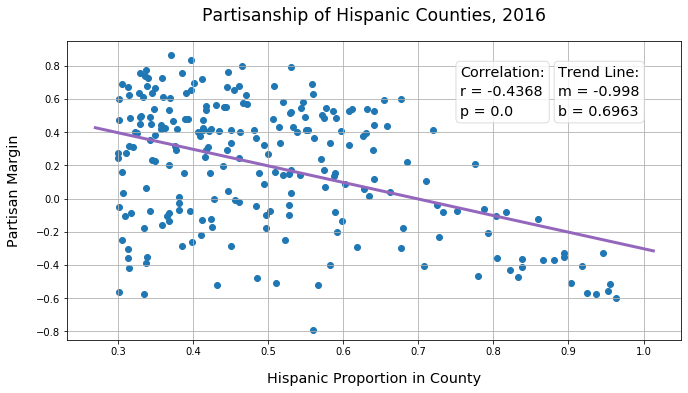

In [18]:
marg_hisp = counties_hisp.join(results[['per_marg_2016','per_marg_2020']])
x = np.array([marg_hisp['per_hisp'].min()-.03,marg_hisp['per_hisp'].max()+.05])

m1, b1 = np.polyfit(marg_hisp['per_hisp'],marg_hisp['per_marg_2016'],1)
r1, p1 = stats.pearsonr(marg_hisp['per_hisp'],marg_hisp['per_marg_2016'])

fig1, ax1 = plt.subplots(figsize=(11,5.5))

ax1.set_ylim([-.85,.95])

ax1.scatter(marg_hisp['per_hisp'],marg_hisp['per_marg_2016'])
ax1.plot(x,m1*x+b1,c='C04',linewidth=3)

ax1.grid()

ax1.text(.64,.75,f"Correlation:\nr = {round(r1,4)}\np = {round(p1,4)}",size='x-large',linespacing=1.5,transform=ax1.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax1.text(.8,.75,f"Trend Line:\nm = {round(m1,4)}\nb = {round(b1,4)}",size='x-large',linespacing=1.5,transform=ax1.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax1.set_xlabel('Hispanic Proportion in County',fontsize='x-large',labelpad=15)
ax1.set_ylabel('Partisan Margin',fontsize='x-large',labelpad=15)
ax1.set_title('Partisanship of Hispanic Counties, 2016',fontsize='xx-large',pad=20)
                         
plt.show()

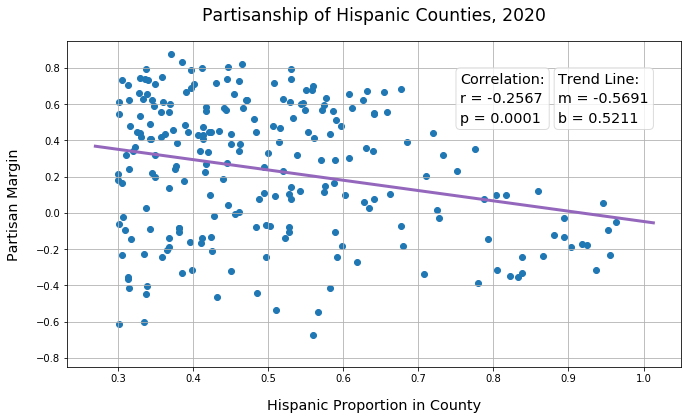

In [19]:
m2, b2 = np.polyfit(marg_hisp['per_hisp'],marg_hisp['per_marg_2020'],1)
r2, p2 = stats.pearsonr(marg_hisp['per_hisp'],marg_hisp['per_marg_2020'])

fig2, ax2 = plt.subplots(figsize=(11,6))
ax2.set_ylim([-.85,.95])

ax2.scatter(marg_hisp['per_hisp'],marg_hisp['per_marg_2020'])
ax2.plot(x,m2*x+b2,c='C04',linewidth=3)

ax2.grid()

ax2.text(.64,.75,f"Correlation:\nr = {round(r2,4)}\np = {round(p2,4)}",size='x-large',linespacing=1.5,transform=ax2.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax2.text(.8,.75,f"Trend Line:\nm = {round(m2,4)}\nb = {round(b2,4)}",size='x-large',linespacing=1.5,transform=ax2.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax2.set_xlabel('Hispanic Proportion in County',fontsize='x-large',labelpad=15)
ax2.set_ylabel('Partisan Margin',fontsize='x-large',labelpad=15)
ax2.set_title('Partisanship of Hispanic Counties, 2020',fontsize='xx-large',pad=20)

plt.show()

Plotting the proportion of Hispanics in a county against the percentage margin in 2016, we see that there is a moderate correlation toward the Democrats with a coefficient of -0.44. Also, the slope of the trend line is -1, meaning generally we'd expect a county with 50% Hispanic population to have a 5% bigger margin in favor of the Democrats than a county with 45% Hispanic population (Note: this is a fairly big oversimplification). However, in 2020 the correlation coefficient and slope dropped to -0.26 and -0.58 respectfully. This shows that the Hispanic identity of a county became a less prevalent factor in determining the partisanship of that county. This is probably expected given what we now know about the big shift toward Republicans from Hispanic communities in 2020, and is a testament to the diversity of the Hispanic community across the country. Thus, we can say that there is isn't much evidence of counties becoming more polarized based on Hispanic identity alone. In fact, there's evidence of the opposite.

Now looking at Black counties, we'll again plot the Black proportion of a county against its margin in 2016 and 2020. We've already seen that Black counties did not shift much at all in 2020, but we hinted that this was not the whole story. Let's take a look at what we mean.

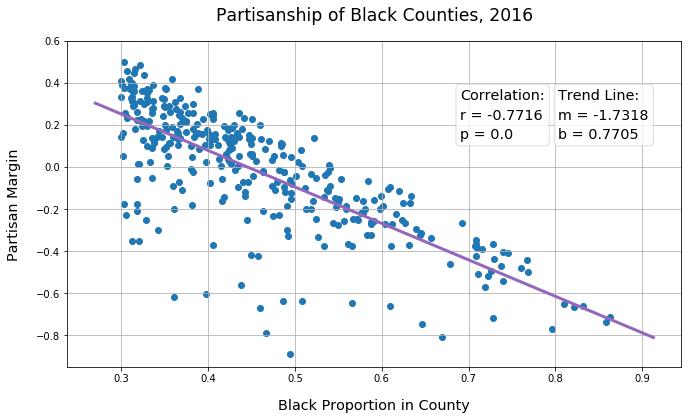

In [20]:
marg_black = counties_black.join(results[['per_marg_2016','per_marg_2020']])

x = np.array([marg_black['per_black'].min()-.03,marg_black['per_black'].max()+.05])

m1, b1 = np.polyfit(marg_black['per_black'],marg_black['per_marg_2016'],1)
r1, p1 = stats.pearsonr(marg_black['per_black'],marg_black['per_marg_2016'])

fig1, ax1 = plt.subplots(figsize=(11,6))
ax1.set_ylim([-.95,.6])

ax1.scatter(marg_black['per_black'],marg_black['per_marg_2016'])
ax1.plot(x,m1*x+b1,c='C04',linewidth=3)

ax1.grid()

ax1.text(.64,.7,f"Correlation:\nr = {round(r1,4)}\np = {round(p1,4)}",size='x-large',linespacing=1.5,transform=ax1.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax1.text(.8,.7,f"Trend Line:\nm = {round(m1,4)}\nb = {round(b1,4)}",size='x-large',linespacing=1.5,transform=ax1.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax1.set_xlabel('Black Proportion in County',fontsize='x-large',labelpad=15)
ax1.set_ylabel('Partisan Margin',fontsize='x-large',labelpad=15)
ax1.set_title('Partisanship of Black Counties, 2016',fontsize='xx-large',pad=20)

plt.show()

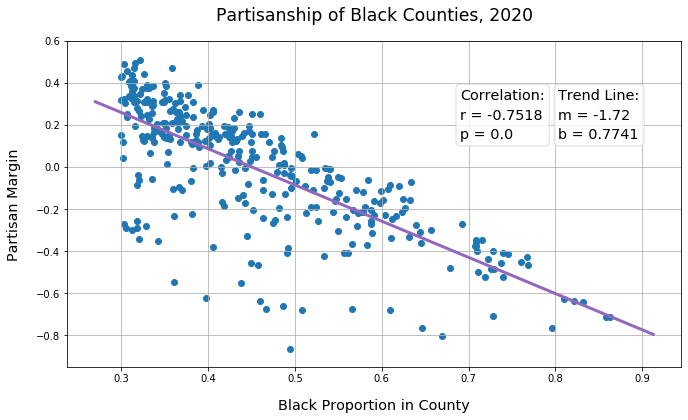

In [21]:
m2, b2 = np.polyfit(marg_black['per_black'],marg_black['per_marg_2020'],1)
r2, p2 = stats.pearsonr(marg_black['per_black'],marg_black['per_marg_2020'])

fig2, ax2 = plt.subplots(figsize=(11,6))

ax2.set_ylim([-.95,.6])

ax2.scatter(marg_black['per_black'],marg_black['per_marg_2020'])
ax2.plot(x,m2*x+b2,c='C04',linewidth=3)

ax2.grid()

ax2.text(.64,.7,f"Correlation:\nr = {round(r2,4)}\np = {round(p2,4)}",size='x-large',linespacing=1.5,transform=ax2.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax2.text(.8,.7,f"Trend Line:\nm = {round(m2,4)}\nb = {round(b2,4)}",size='x-large',linespacing=1.5,transform=ax2.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax2.set_xlabel('Black Proportion in County',fontsize='x-large',labelpad=15)
ax2.set_ylabel('Partisan Margin',fontsize='x-large',labelpad=15)
ax2.set_title('Partisanship of Black Counties, 2020',fontsize='xx-large',pad=20)

plt.show()

In both 2016 and 2020, it's clear the more Black voters there are in a county, the more Democratic it will vote. There is both a strong correlation and a steep trend line slope, showing that Black identity appears to be an important factor in the partisanship of counties. This implies there is some strong polarization when it comes to Black identity, but this isn't new, as exit polls have showed Black support for the Democratic candidate near 90% for the last 20 years. With that large of a gap, it's hard to expect the polarization to grow even further, and it did not in 2020.

To end our discussion on racial polarization, we'll look at scatter plots of White counties in the same way we did Hispanic and Black counties.

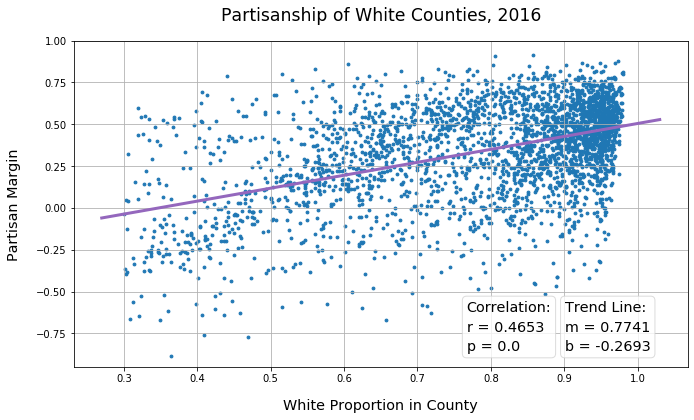

In [22]:
marg_white = counties_white.join(results[['per_marg_2016','per_marg_2020']])

x = np.array([marg_white['per_white'].min()-.03,marg_white['per_white'].max()+.05])

m1, b1 = np.polyfit(marg_white['per_white'],marg_white['per_marg_2016'],1)
r1, p1 = stats.pearsonr(marg_white['per_white'],marg_white['per_marg_2016'])

fig1, ax1 = plt.subplots(figsize=(11,6))

ax1.set_ylim([-.95,1])

ax1.scatter(marg_white['per_white'],marg_white['per_marg_2016'],s=8)
ax1.plot(x,m1*x+b1,c='C04',linewidth=3)
ax1.grid()

ax1.text(.64,.05,f"Correlation:\nr = {round(r1,4)}\np = {round(p1,4)}",size='x-large',linespacing=1.5,transform=ax1.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax1.text(.8,.05,f"Trend Line:\nm = {round(m1,4)}\nb = {round(b1,4)}",size='x-large',linespacing=1.5,transform=ax1.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax1.set_xlabel('White Proportion in County',fontsize='x-large',labelpad=15)
ax1.set_ylabel('Partisan Margin',fontsize='x-large',labelpad=15)
ax1.set_title('Partisanship of White Counties, 2016',fontsize='xx-large',pad=20)

plt.show()

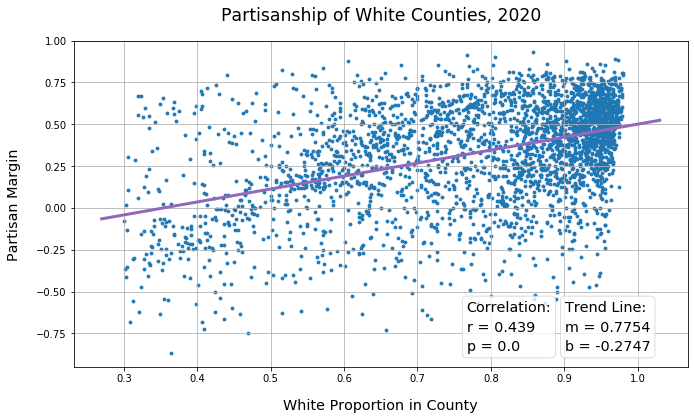

In [23]:
marg_white = counties_white.join(results[['per_marg_2016','per_marg_2020']])

x = np.array([marg_white['per_white'].min()-.03,marg_white['per_white'].max()+.05])

m2, b2 = np.polyfit(marg_white['per_white'],marg_white['per_marg_2020'],1)
r2, p2 = stats.pearsonr(marg_white['per_white'],marg_white['per_marg_2020'])

fig2, ax2 = plt.subplots(figsize=(11,6))

ax2.set_ylim([-.95,1])

ax2.scatter(marg_white['per_white'],marg_white['per_marg_2020'],s=8)
ax2.plot(x,m2*x+b2,c='C04',linewidth=3)

ax2.grid()

ax2.text(.64,.05,f"Correlation:\nr = {round(r2,4)}\np = {round(p2,4)}",size='x-large',linespacing=1.5,transform=ax2.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax2.text(.8,.05,f"Trend Line:\nm = {round(m2,4)}\nb = {round(b2,4)}",size='x-large',linespacing=1.5,transform=ax2.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax2.set_xlabel('White Proportion in County',fontsize='x-large',labelpad=15)
ax2.set_ylabel('Partisan Margin',fontsize='x-large',labelpad=15)
ax2.set_title('Partisanship of White Counties, 2020',fontsize='xx-large',pad=20)

plt.show()

There is a decent correlation between how White a county is and how much it voted Republican, with a correlation coefficient of around .45 for both 2016 and 2020. This suggests there is a not insignificant degree of polarization based on White identity, but it is not nearly as much as it is for Black identity. However, similar to Black identity, this polarization did not change from 2016 to 2020.

Our final indicator for polarization will be education and income. In our initial analysis, we saw that less educated counties shifted toward Republicans and more educated ones shifted toward Democrats. But does this mean the US is becoming more polarized on this front? Let's look at the scatter plots to see.

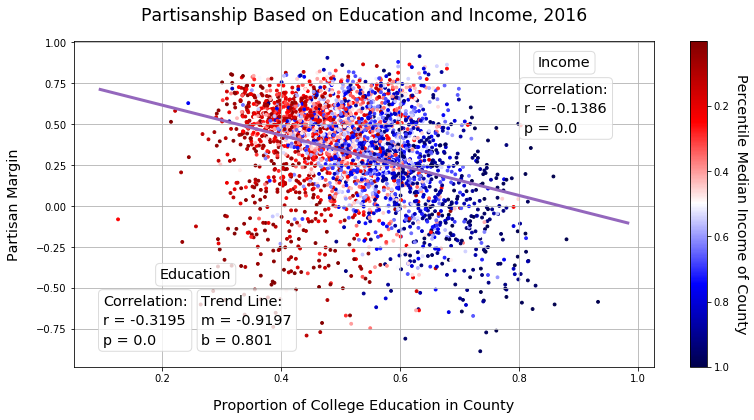

In [24]:
marg_edu_income = counties_edu_income.copy()

x = np.array([marg_edu_income['per_col'].min()-.03,marg_edu_income['per_col'].max()+.05])

m1, b1 = np.polyfit(marg_edu_income['per_col'],marg_edu_income['per_marg_2016'],1)
r1, p1 = stats.pearsonr(marg_edu_income['per_col'],marg_edu_income['per_marg_2016'])
ri1, pi1 = stats.pearsonr(marg_edu_income['median_income_pct'],marg_edu_income['per_marg_2016'])

fig1, ax1 = plt.subplots(figsize=(13,6))

s1=ax1.scatter(marg_edu_income['per_col'],marg_edu_income['per_marg_2016'],s=8,c=marg_edu_income['median_income_pct'],cmap='seismic_r')
ax1.plot(x,m1*x+b1,c='C04',linewidth=3)

cbar1 = fig1.colorbar(s1)
cbar1.ax.invert_yaxis()
cbar1.set_label('Percentile Median Income of County',size='x-large', rotation=270,labelpad=18)

ax1.grid()

ax1.text(.21,.27,'Education',size='x-large',linespacing=1.5,transform=ax1.transAxes,ha='center',
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax1.text(.05,.07,f"Correlation:\nr = {round(r1,4)}\np = {round(p1,4)}",size='x-large',linespacing=1.5,transform=ax1.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax1.text(.22,.07,f"Trend Line:\nm = {round(m1,4)}\nb = {round(b1,4)}",size='x-large',linespacing=1.5,transform=ax1.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax1.text(.8,.92,'Income',size='x-large',linespacing=1.5,transform=ax1.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax1.text(.775,.72,f"Correlation:\nr = {round(ri1,4)}\np = {round(pi1,4)}",size='x-large',linespacing=1.5,transform=ax1.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax1.set_xlabel('Proportion of College Education in County',fontsize='x-large',labelpad=15)
ax1.set_ylabel('Partisan Margin',fontsize='x-large',labelpad=15)
ax1.set_title('Partisanship Based on Education and Income, 2016',fontsize='xx-large',pad=20)

plt.show()

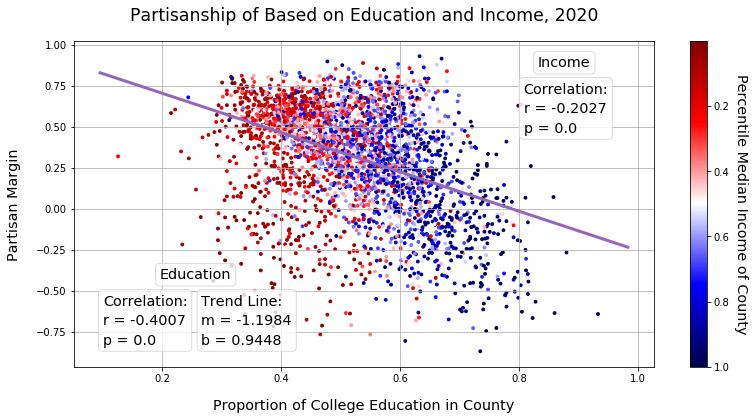

In [26]:
marg_edu_income = counties_edu_income.copy()

x = np.array([marg_edu_income['per_col'].min()-.03,marg_edu_income['per_col'].max()+.05])

m2, b2 = np.polyfit(marg_edu_income['per_col'],marg_edu_income['per_marg_2020'],1)
r2, p2 = stats.pearsonr(marg_edu_income['per_col'],marg_edu_income['per_marg_2020'])
ri2, pi2 = stats.pearsonr(marg_edu_income['median_income_pct'],marg_edu_income['per_marg_2020'])

fig2, ax2 = plt.subplots(figsize=(13,6))

s2=ax2.scatter(marg_edu_income['per_col'],marg_edu_income['per_marg_2020'],s=8,c=marg_edu_income['median_income_pct'],cmap='seismic_r')
ax2.plot(x,m2*x+b2,c='C04',linewidth=3)

cbar2 = fig2.colorbar(s2)
cbar2.ax.invert_yaxis()
cbar2.set_label('Percentile Median Income of County',size='x-large', rotation=270,labelpad=18)

ax2.grid()

ax2.text(.21,.27,'Education',size='x-large',linespacing=1.5,transform=ax2.transAxes,ha='center',
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax2.text(.05,.07,f"Correlation:\nr = {round(r2,4)}\np = {round(p1,4)}",size='x-large',linespacing=1.5,transform=ax2.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax2.text(.22,.07,f"Trend Line:\nm = {round(m2,4)}\nb = {round(b2,4)}",size='x-large',linespacing=1.5,transform=ax2.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax2.text(.8,.92,'Income',size='x-large',linespacing=1.5,transform=ax2.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))
ax2.text(.775,.72,f"Correlation:\nr = {round(ri2,4)}\np = {round(pi2,4)}",size='x-large',linespacing=1.5,transform=ax2.transAxes,
        bbox=dict(boxstyle='round',facecolor='white',alpha=.8,edgecolor='lightgray'))

ax2.set_xlabel('Proportion of College Education in County',fontsize='x-large',labelpad=15)
ax2.set_ylabel('Partisan Margin',fontsize='x-large',labelpad=15)
ax2.set_title('Partisanship of Based on Education and Income, 2020',fontsize='xx-large',pad=20)

plt.show()

The correlation coefficient and slope in 2016 show a moderate but noticable relationship between college education and partisanship. Then in 2020, the correlation became stronger and the slope became steeper. This is almost the textbook definition of polarization, and is of great interest. The Republican party used to be the party of the educated upper/middle class. This appears to be changing, and the difference is becoming more stark. The question remains to be seen whether this trend continues and what it means for the future.

## Conclusion

In this report we looked at how US counties shifted in voting patterns from 2016 to 2020 based on three main factors: rural/urban distinction, race, and education. Lets summarize some of the conclusions we've made for each.

#### Rural/Urban Distinction:
Rural counties are becoming more Republican and urban counties are becoming more Democratic. The already huge gap between how metro and non-metro counties has become even larger, increasing the polarization of the country in this respect.

#### Race:
Hispanic counties seem to be shifting their voting patterns. The biggest Republican swinging counties between 2016 and 2020 were majority Hispanic, and what used to be an expected left-leaning bloc now appears to be changing to a more neutral one. White and Black counties were Republican and Democrat leaning couties respectively in 2016. However, their partisanship did not seem to shift in either directionin 2020, which, along with our knowledge of Hispanic counties, leads us to conclude that the country did not become more polarized on race, at least in terms of picking presidential candidates.

#### Education and Income:
In 2016 there was a pattern of wealthier, college educated counties voting more Democratic, and poorer, non-college educated counties voting more Republican. In 2020, this pattern became even more pronounced, suggesting a more permanent shift in each party's electorate. As such, it appears the US is becoming more polarized than it already is on education and income.

These conclusions only provide a surface level explanation of the extremely complex nature of US politics. However, even on the surface, the data shows that the US is polarized in many ways.